## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):


### Confidence Intervals:
1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

### Chi-squared tests:
4. Take a dataset that we have used in the past in class that has **categorical** variables. Pick two of those categorical variables and run a chi-squared tests on that data
  - By hand using Numpy
  - In a single line using Scipy


##THE CODE

###Import

In [0]:
# Import the libraries
from scipy.stats import ttest_ind, ttest_1samp
import pandas as pd
import numpy as np

In [0]:
# I'll upload the dataset via url.
# To do that i'll first save the link into a variable
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data'

In [21]:
# Now create a dataset. The original onw will be 'df'
df=pd.read_csv(url)
df.sample(5)

,republican,n,y,n.1,y.1,y.2,y.3,n.2,n.3,n.4,y.4,?,y.5,y.6,y.7,n.5,y.8
66,republican,n,y,n,y,y,y,n,n,n,y,n,y,y,y,n,n
198,democrat,y,y,n,n,n,n,y,y,?,n,y,n,n,n,y,?
54,republican,n,y,n,y,y,y,n,n,n,y,y,y,y,y,n,n
191,democrat,n,n,n,n,n,y,y,y,y,n,y,n,n,y,y,y
389,democrat,?,?,n,n,?,y,?,n,n,n,y,y,n,y,n,?


In [22]:
# The columns are not formated for easy use. Rename them
column_headers = ['party','handicapped-infants','water-project',
                  'budget','physician-fee-freeze','el-salvador-aid',
                  'religious-groups','anti-satellite-ban',
                  'aid-to-contras','mx-missile','immigration',
                  'synfuels', 'education', 'right-to-sue','crime',
                  'duty-free','south-africa']
# No recreate the dataframe with new column names and converting '?' into NaNs
df=pd.read_csv(url, header=None, names=column_headers, na_values='?')
# "na_values='?'" converts question marks into NaNs
print(df.shape)
df.head()

(435, 17)


,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,n,y,n,y,y,y,n,n,n,y,NaN,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,NaN
2,democrat,NaN,y,y,NaN,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,NaN,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,NaN,y,y,y,y


###Analysis and Cleaning

In [23]:
# Let's covert al 'y' and 'n' into numeric
df=df.replace({'y':1,'n':0})
print(df.shape)
df.head()

(435, 17)


,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
2,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0


In [24]:
# Count the NaNs
df.isnull().sum()
# We've got plenty of them for such a small dataset

party                     0
handicapped-infants      12
water-project            48
budget                   11
physician-fee-freeze     11
el-salvador-aid          15
religious-groups         11
anti-satellite-ban       14
aid-to-contras           15
mx-missile               22
immigration               7
synfuels                 21
education                31
right-to-sue             25
crime                    17
duty-free                28
south-africa            104
dtype: int64

In [25]:
# Let's drop the NaNs so they don't ruin our tests
df=df.dropna(how='any')
print(df.shape)

(232, 17)


In [26]:
# We have 2 big categories: democrats and republicans
# Let's store them in 2 separate datasets
dem=df[df['party']=='democrat']
print(dem.shape)
dem.head()

(124, 17)


,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
5,democrat,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
19,democrat,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
23,democrat,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
25,democrat,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
26,democrat,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0


In [27]:
# Same for republicans
rep=df[df['party']=='republican']
print(rep.shape)
rep.head()

(108, 17)


,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
8,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
28,republican,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
30,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
33,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
35,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0


###1. Generate and numerically represent a confidence interval

In [28]:
# As we can see from the shapes of those datasets,
# we have 124 democrats and 108 republicans.
# That's after we deleted the rows with NaNs.
# However, in the original dataframe we still had more democrats over republicans.

# Let's analyze the voting on the issue of immigration,
# since it had the least amount of NaNs in the original dataset
print(dem['immigration'].mean())
print(rep['immigration'].mean())
ttest_ind(dem['immigration'], rep['immigration'], nan_policy='omit')

0.532258064516129
0.5740740740740741


Ttest_indResult(statistic=-0.6366340860076748, pvalue=0.5249963080040427)

In [0]:
# Import the stats library
import scipy.stats as stats

In [0]:
# Define a function to calculate the confidence interval
def conf_interval(data, confidence=0.95):
    """
    Calculate a confidence interval around a sample mean for given data.
    Using t-distribution and two-tailed test, default 95% confidence. 

    Arguments:
    data - iterable (list or numpy array) of sample observations
    confidence - level of confidence for the interval

    Returns:
    tuple of (mean, lower bound, upper bound)
    """
    data_array=np.array(data)
    data_mean=np.mean(data)
    n=len(data)
    stderr=np.std(data_array,ddof=1)/np.sqrt(n)
    moe=stderr*stats.t.ppf((1+confidence)/2,n-1)    #moe-Margin Of Error, look up the corresponding tstat
    return (data_mean,data_mean-moe,data_mean+moe)

In [33]:
# mean
df['immigration'].mean()

0.5517241379310345

In [32]:
# what's the conf interval 
conf_interval(df['immigration'])

# mean, upper bound, lower bound.

(0.5517241379310345, 0.48725422311179667, 0.6161940527502723)

###2. Graphically (with a plot) represent the confidence interval

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

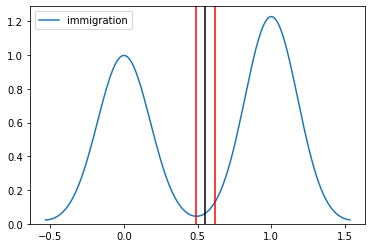

In [35]:
# kernel density estimate
sns.kdeplot(df['immigration'])
CI=conf_interval(df['immigration'])
plt.axvline(x=CI[1],color='red')
plt.axvline(x=CI[2],color='red')
plt.axvline(x=CI[0],color='k');

###3. Interpret the confidence interval - what does it tell you about the data and its distribution?

In this case, the confidence interval includes  0.5  - which is the natural null hypothesis (there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

###4. Take a dataset that we have used in the past in class that has categorical variables.

## Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.
3. Refactor your code so it is elegant, readable, and can be easily run for all issues.

## Resources

- [Interactive visualize the Chi-Squared test](https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html)
- [Calculation of Chi-Squared test statistic](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
- [Visualization of a confidence interval generated by R code](https://commons.wikimedia.org/wiki/File:Confidence-interval.svg)
- [Expected value of a squared standard normal](https://math.stackexchange.com/questions/264061/expected-value-calculation-for-squared-normal-distribution) (it's 1 - which is why the expected value of a Chi-Squared with $n$ degrees of freedom is $n$, as it's the sum of $n$ squared standard normals)